In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import minmax_scale
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import hdbscan
import sklearn.cluster as cluster

import napari

from scipy import stats
from skimage.filters import threshold_li, threshold_otsu

import tifffile

In [8]:
##### reading necessary files ####

M = pd.read_csv('./Umap254genesNoDilation.csv',header=None,)
Cell = pd.read_csv('CenterofMass.csv',header=None,)
annot = pd.read_csv("./MouseGenes3.csv",header=None).iloc[:254,1]

print('M: row=cell,col=genes matrix:',M.shape)
print('Cell: XYZ space coordinate of cells:',Cell.shape)
print('annot: gene names:',annot.shape)

M: row=cell,col=genes matrix: (11029, 254)
Cell: XYZ space coordinate of cells: (11029, 3)
annot: gene names: (254,)


In [11]:
######### three input files into one matrix #######
M.columns = annot ### label columns with genes
Cell.columns = ['x','y','z']
m = pd.concat([M,Cell],axis=1) ### add xyz to the matrix
print(m.shape)
m

(11029, 257)


,F2r,Lhx1,Slc38a4,Prom1,Nexn,Rab27b,Midn,Hells,Grsf1,Snu13,...,Efcab6,Hoxb4,Rnf213,Spred2,Cyfip2,Nrcam,Fgfr2,x,y,z
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,3,0,0,3,789.413613,611.352898,43.583693
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,795.262222,547.996667,25.930556
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,793.679558,576.179188,35.571429
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,849.915088,600.801457,39.509677
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,828.988586,621.795104,35.989136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11024,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,278.930031,637.047799,593.469882
11025,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,335.080922,714.876154,596.650008
11026,0,0,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,291.837102,695.601075,598.870125
11027,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,302.786475,619.632200,598.052271


(254,)
min sum spots per gene:  260.8174204449091
genes removed:  68
min sum spots per cell:  40
cells removed:  484


C:\Users\kimj7\AppData\Local\anaconda3\envs\napari_umap\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kimj7\AppData\Local\anaconda3\envs\napari_umap\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


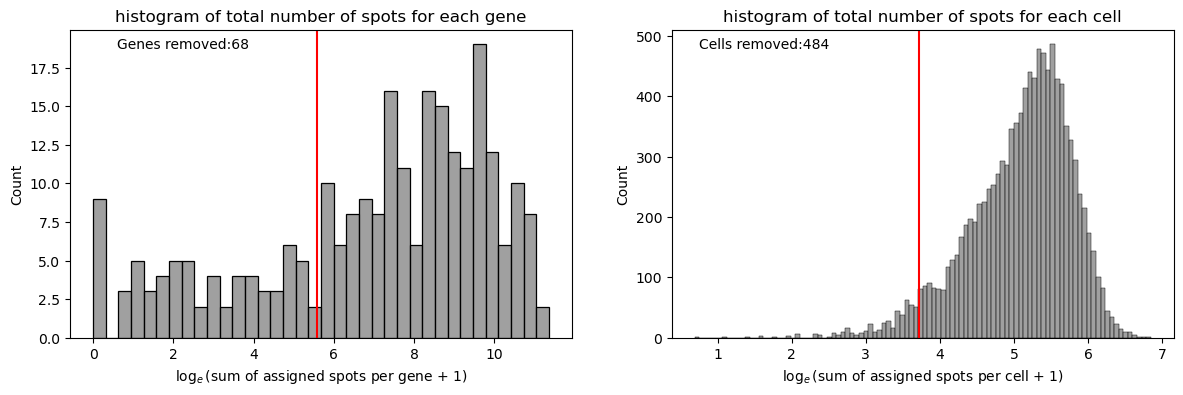

In [16]:
f = plt.figure(figsize=(22, 4))

ax0 = f.add_subplot(1,3,1)
ax1 = f.add_subplot(1,3,2)

########################## thresholding genes with low counts ###############################
dat = m.iloc[:,:-3]
x0 = np.log1p(np.sum(dat,axis=0).to_numpy()) #### sum per gene, in log space
print(x0.shape)

##### otsu threshold based on histogram ####
thresh_g = threshold_otsu(x0)

##### plot histogram and the threshold ####
h0 = sns.histplot(ax=ax0,data=x0,bins=36,color='grey')
h0.axvline(thresh_g,color='red')
g_removed = np.sum(x0<=thresh_g) ### number of genes removed
##### axis labeling ####
ax0.text(ax0.get_xlim()[1]*0.05, ax0.get_ylim()[1]*0.94, 'Genes removed:'+str(g_removed)) # print the values on the histogram
ax0.set_title('histogram of total number of spots for each gene')
ax0.set_xlabel('$\log_{e}$(sum of assigned spots per gene + 1)')

##### print threshold in linear space and the number of genes removed #####
print('min sum spots per gene: ',np.expm1(thresh_g))
print('genes removed: ', str(g_removed))

############################################################################################

########################## thresholding cells with low counts ###############################

x1 = np.log1p(np.sum(dat,axis=1).to_numpy()) #### sum per cell, in log space

thresh_c = 40 #### arbitrarily chosen, results in < 5% cells being removed, value in linear space

##### plot histogram and the threshold ####
h1 = sns.histplot(ax=ax1,data=x1,bins=100,color='grey')
h1.axvline(np.log1p(thresh_c),color='red')

##### axis labeling #####
ax1.text(ax1.get_xlim()[1]*0.05+ax1.get_xlim()[0], ax1.get_ylim()[1]*0.94, 'Cells removed:'+str(c_removed)) # print the values on the histogram
ax1.set_title('histogram of total number of spots for each cell')
ax1.set_xlabel('$\log_{e}$(sum of assigned spots per cell + 1)')

##### print threshold and the number of cells removed #####

c_removed = np.sum(x1<=np.log1p(thresh_c))
print('min sum spots per cell: ',thresh_c)
print('cells removed: ', str(c_removed))




In [53]:
def filter_matrix(m_xyz_df, tcell, tgene, norm=False):
    mx = m_xyz_df.iloc[:,:-3]
    mcell = m_xyz_df[['x','y','z']]
    
    #### cells with low count ####
    cell_rm = np.sum(mx,axis=1)<=tcell
    print('removed cell count:', str(np.sum(cell_rm)))
    
    ### genes with low counts ####
    gene_rm = np.sum(mx,axis=0)<=tgene
    print('removed gene count:', str(np.sum(gene_rm)))        
    
    ### remove ##
    mx_filter = mx.iloc[~cell_rm.values,~gene_rm.values]

    ##### normalize ####
    if norm==True:
        mx_norm = mx_filter.div(mx_filter.sum(axis=1), axis=0)*10_000
    else:
        mx_norm = mx_filter
    #######################
    mcell_filter = mcell.iloc[~cell_rm.values,:]
    o = pd.concat([mx_norm,mcell_filter],axis=1)#.reset_index(drop=True)
    
    return o

Thresh_gene = np.expm1(thresh_g) #### thresh_g is otsu in log space, so revert back to linear space
Thresh_cell = thresh_c    #### = 40


print('Thresh_cell: ',Thresh_cell)
print('Thresh_gene: ',Thresh_gene)
m_filter = filter_matrix(m,tcell=Thresh_cell,tgene=Thresh_gene,norm=False).reset_index(drop=True)    # just filters data based on thresholds
m_norm = filter_matrix(m,tcell=Thresh_cell,tgene=Thresh_gene,norm=True).reset_index(drop=True)       # filters and normalizes sum per cell = 10_000, ie. assumes constant 'total RNA' per cell


Thresh_cell:  40
Thresh_gene:  260.8174204449091
removed cell count: 484
removed gene count: 68
removed cell count: 484
removed gene count: 68


In [21]:
##### new one ########
# pick a good looking umap cluster #
# see UMAP homepage for details about parameters

N = 400    ## n_neighbors 
C = 160    ## cluster size
S = 16   ## sample size


t_mat = m_filter.iloc[:,:-3]  ## we will use filtered matrix, remove the last three columns which are xyz space coordinates
clusterable_embedding = umap.UMAP(random_state=42,min_dist=0, n_neighbors=N,n_components=2).fit_transform(t_mat)   ## make umap, with fixed random state, so we always get the same umap shape
labels = hdbscan.HDBSCAN(min_cluster_size=C,min_samples=S).fit_predict(clusterable_embedding) ## call clusters on umap


C:\Users\kimj7\AppData\Local\anaconda3\envs\napari_umap\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [22]:
### plotting umap can be slow, and random state dependent, it's good to save the umap coordinates and cluster labels
df = pd.DataFrame(clusterable_embedding)
df['labels'] = labels
df.to_csv('./UMAP_notebook/otsu_min40_neighbor400_c160_s16_UMAP_labels.csv',header=None,index=False) 

In [30]:
#### read the data and put some column labels ####
embedding_labels = pd.read_csv('./UMAP_notebook/otsu_min40_neighbor400_c160_s16_UMAP_labels.csv',header=None)    ### read the saved data
embedding_labels.columns = ['UMAP 1', 'UMAP 2', 'clusters'] #### make some intuitive column labels
print(embedding_labels.shape)


(10545, 3)


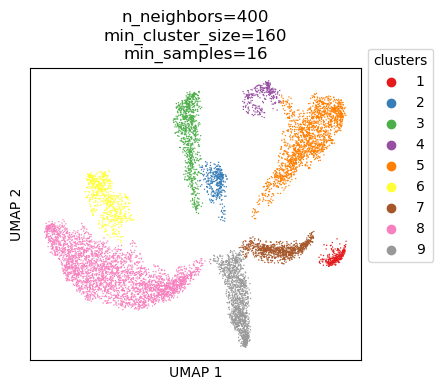

In [31]:
##### take a quick look at the umap ####
f = plt.figure(figsize=(8, 4))

labels = embedding_labels.clusters ### clusters label
clusters = labels>=0 #### boolean for clusters >=0, -1 indicates not clustered by hdbscan

#### label clusters ####
d = embedding_labels.loc[clusters,:].copy()
d['clusters'] = labels[clusters]+1   ### we will add 1, so clusters start from 1, not 0


#### plot ####
ax = f.add_subplot(1,2,1)
a = sns.scatterplot(ax=ax,x='UMAP 1',y='UMAP 2',data=d,hue='clusters',palette='Set1',s=1,linewidth=0)

a.set_xticks([])
a.set_yticks([])  
a.set_xlabel('UMAP 1')
a.set_ylabel('UMAP 2')

a.set_title(
    'n_neighbors='+str(N)+
    '\nmin_cluster_size='+str(C)+
    '\nmin_samples='+str(S)
)
a.legend(loc='center left', bbox_to_anchor=(1, 0.7),title='clusters')

plt.tight_layout()
plt.show() 

In [32]:
################# completely unnecessary step ############### swapping cluster numbers so it goes from left to right ....
embedding_labels['clusters']
bool_1 = embedding_labels.clusters == (8-1)
bool_2 = embedding_labels.clusters == (6-1)
bool_3 = embedding_labels.clusters == (3-1)
bool_4 = embedding_labels.clusters == (2-1)
bool_5 = embedding_labels.clusters == (9-1)
bool_6 = embedding_labels.clusters == (4-1)
bool_7 = embedding_labels.clusters == (5-1)
bool_8 = embedding_labels.clusters == (7-1)
bool_9 = embedding_labels.clusters == (1-1)

embedding_labels['clusters_swap'] = -1
embedding_labels.loc[bool_1,'clusters_swap'] = 0
embedding_labels.loc[bool_2,'clusters_swap'] = 1
embedding_labels.loc[bool_3,'clusters_swap'] = 2
embedding_labels.loc[bool_4,'clusters_swap'] = 3
embedding_labels.loc[bool_5,'clusters_swap'] = 4
embedding_labels.loc[bool_6,'clusters_swap'] = 5
embedding_labels.loc[bool_7,'clusters_swap'] = 6
embedding_labels.loc[bool_8,'clusters_swap'] = 7
embedding_labels.loc[bool_9,'clusters_swap'] = 8

In [33]:
### save again with extra column indicateing swapped cluster
embedding_labels.to_csv('./UMAP_notebook/otsu_min40_neighbor400_c160_s16_UMAP_labels_clusterswap.csv',header=None,index=False)

In [34]:
## read data ##
embedding_labels = pd.read_csv('./UMAP_notebook/otsu_min40_neighbor400_c160_s16_UMAP_labels_clusterswap.csv',header=None)
embedding_labels.columns = embedding_labels.columns = ['UMAP 1', 'UMAP 2', 'clusters','clusters_swap']


In [35]:
#### not necessary, but we chose 9 color/alpha combinations for the 9 clusters ####
my_COLORS = [(170/255,0,1),(0,0.687,1),(0,1,0),(0,0,0),(1,1,0),(0.967,0.639,0),(1,0,0),(0.00,1,0.751),sns.color_palette("tab20c",20)[17]]
my_ALPHAS = [1,1,0.77,1,1,1,0.75,0.5,0.6]

[3223, 678, 872, 361, 1310, 286, 1777, 844, 281] [1 2 3 4 5 6 7 8 9]
8.66


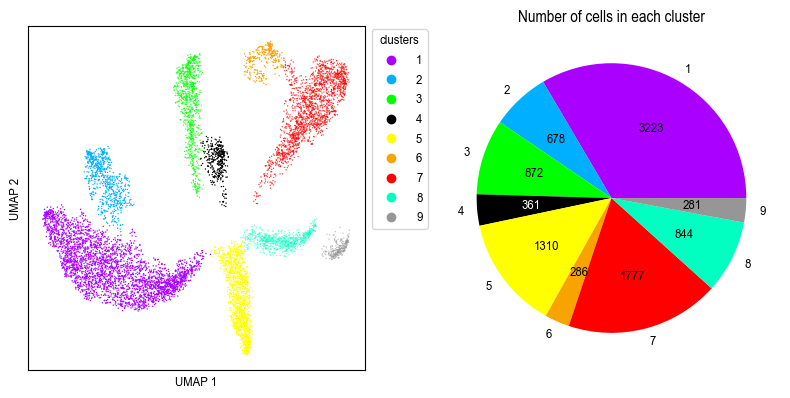

In [38]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.stretch'] = 'condensed'

##### take a quick look at the umap ####
f = plt.figure(figsize=(8, 4))


labels = embedding_labels.clusters_swap
clusters = labels>=0

#### label clusters ####
d = embedding_labels.loc[clusters,:].copy()
d['clusters_swap'] = labels[clusters]+1

#### label alpha ####
d['Alpha'] = 0.0
for i in np.unique(d.clusters_swap):
    d.loc[d.clusters_swap == i,'Alpha'] = my_ALPHAS[i-1]

#### plot ####
ax = f.add_subplot(1,2,1)
a = sns.scatterplot(ax=ax,x='UMAP 1',y='UMAP 2',data=d,hue='clusters_swap',palette=my_COLORS,s=1,linewidth=0,alpha=d['Alpha'])

a.set_xticks([])
a.set_yticks([])  
a.set_xlabel('UMAP 1')
a.set_ylabel('UMAP 2')

a.legend(loc='center left', bbox_to_anchor=(1, 0.7),title='clusters')

ax1 = f.add_subplot(1,2,2)

# declaring data 
nCells = []
for i in np.unique(labels[clusters]):
    nCells.append(np.sum(labels[clusters] == i))
    
keys = np.unique(d.clusters_swap)
print(nCells,keys)

  
# define Seaborn color palette to use 
palette_color = sns.color_palette(my_COLORS) 

def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{v:d}'.format(v=val)
    return my_format

# plotting data on chart 
_, _, autotexts = ax1.pie(nCells, labels=keys, colors=my_COLORS, autopct=autopct_format(nCells)) 
pie_txt = ['black','black','black','white','black','black','black','black','black']
for i in range(len(autotexts)):
    autotext = autotexts[i]
    autotext.set_color(pie_txt[i])
ax1.set_title('Number of cells in each cluster')

unclustered = round(sum(labels<0)/len(labels)*100,2)
print(unclustered)


plt.tight_layout()
plt.show() 

In [39]:
f.savefig("./UMAP_notebook/UMAP_9clusters.pdf",dpi=300, bbox_inches='tight')

In [41]:
### for napari ###
#### segmentation data ####
# not necessary but gives structure to visualization #
seg = tifffile.imread('./DummyData/Segmentation.tiff')
seg[seg>0] = 1000  # segmentation data has different non-zero value for different cells, just turn them all to 1000
print('z,y,x:',seg.shape) # note that tifffile is read in z-y-x, see tifffile for more details on the format

z,y,x: (648, 1152, 1152)


In [44]:
###### napari view ######

cluster_uniq = np.unique(labels)[1:] ### clusters exclude 0
print(cluster_uniq)
s = 8 # blob size

########################### lots of clusters

#viewer = napari.view_points([b],face_color='black', size=s, name='unclustered', n_dimensional=True)
viewer = napari.view_image(seg,name='seg',)
viewer.theme = 'light'
COORD = m_filter.reset_index(drop=True)[['z','y','x']].to_numpy()   ### plot zyx to match the segmentation tiff

for c in cluster_uniq:
    COLOR = np.array(my_COLORS[c])
    print(COLOR)
    cluster_bool = labels==c
    viewer.add_points(COORD[cluster_bool], face_color=COLOR, size=s, name=str(c+1),n_dimensional=True,shading='spherical',opacity=my_ALPHAS[c])
    

[0 1 2 3 4 5 6 7 8]
[0.66666667 0.         1.        ]
[0.    0.687 1.   ]
[0 1 0]
[0 0 0]
[1 1 0]
[0.967 0.639 0.   ]
[1 0 0]
[0.    1.    0.751]
[0.58823529 0.58823529 0.58823529]


In [51]:
screenshot = viewer.screenshot()

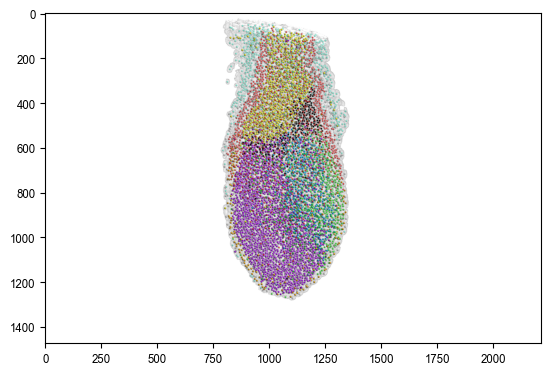

In [52]:
plt.imshow(screenshot)